### Joshua Lim - ML HW03

In [1]:
#Qn 1
import numpy as np
#Matrix factorization implementation credits: 
#http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/
def matrix_factorization(R, P, Q, K, steps=100000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > -1: #Dont compute loss over missing entries
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > -1: #Dont compute loss over missing entries
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
#         if e < 1e-010:
#             break
    return P, Q.T

#Incomplete matrix. Denote missing entries with -1
R = [
     [0,1,-1],
     [1,-1,1],
     [-1,1,2],

    ]

R = np.array(R)

N = len(R)
M = len(R[0])
K = 1

P = np.random.rand(N,K)
Q = np.random.rand(M,K)

nP, nQ = matrix_factorization(R, P, Q, K)
print ('=====A=====')
print(np.dot(nP,nQ.T))
print ('=====U=====')
print (nP)
print ('=====V=====')
print (nQ)

=====A=====
[[ 0.47940124  0.60332336  0.94402589]
 [ 0.60352853  0.75953675  1.18845449]
 [ 0.94437633  1.18849149  1.85964413]]
=====U=====
[[ 0.69854489]
 [ 0.87941318]
 [ 1.37606915]]
=====V=====
[[ 0.68628552]
 [ 0.86368588]
 [ 1.35141765]]


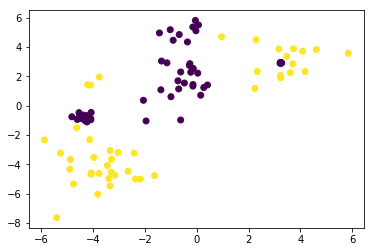

In [2]:
#Qn 2
import matplotlib.pyplot as plt
csv = 'https://www.dropbox.com/s/wt45tvn9ig3o7vu/kernel.csv?dl=1'
data = np.genfromtxt(csv,delimiter =',')
X = data[:,1:]
Y = data[:,0]
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

In [3]:
#Qn 2a
from sklearn.svm import SVC
model = SVC(kernel='rbf', gamma=0.5)
model.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [4]:
#Qn 2b
def decision(x1,x2,model):
    x = np.array([[x1,x2],[0,0]])
    value,_ = model.decision_function(x)
    return value

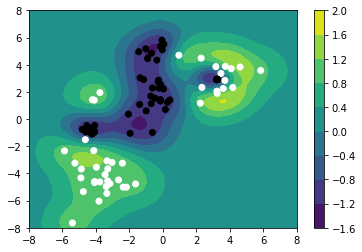

In [5]:
#Qn 2c
vdecision = np.vectorize(decision,excluded=[2])
x1list = np.linspace(-8.0,8.0,100)
x2list = np.linspace(-8.0,8.0,100)
X1, X2 = np.meshgrid(x1list,x2list)
Z = vdecision(X1,X2,model)
cp = plt.contourf(X1,X2,Z)
plt.colorbar(cp)
plt.scatter(X[:,0],X[:,1],c=Y,cmap='gray')
plt.show()

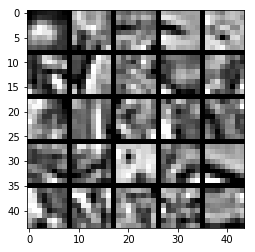

In [6]:
#Qn 3
#utils link 'https://www.dropbox.com/s/e7opv0iybk4gr7a/utils.py?dl=1'
#image link 'https://www.dropbox.com/s/c9crd7fjk1523wh/images.npy?dl=1'
from numpy.linalg import norm
from scipy.optimize import fmin_l_bfgs_b as minimize
from utils import normalize, tile_raster_images, sigmoid
from utils import ravelParameters, unravelParameters
from utils import initializeParameters
from utils import computeNumericalGradient

nV = 8*8 # number of visible units
nH = 25 # number of hidden units
dW = 0.0001 # weight decay term
sW = 3 # sparsity penalty term
npy = 'images.npy'
X = normalize(np.load(npy))
plt.imshow(tile_raster_images(X=X, img_shape=(8,8), tile_shape=(5,5), tile_spacing=(1,1)), cmap='gray')
plt.show()

In [7]:
#Qn 3a
def sparseAutoencoderCost(theta,nV,nH,dW,sW,X):
    W1,W2,b1,b2 = unravelParameters(theta,nH,nV)
    n = X.shape[0]
    z2 = np.dot(X, W1) + b1.T
    a2 = sigmoid(z2)
    z3 = np.dot(a2, W2) + b2.T 
    a3 = sigmoid(z3)
    eps = a3 - X
    loss = (norm(eps) ** 2) / 2 / n
    decay = (norm(W1) ** 2 + norm(W2) ** 2) / 2
    # Compute sparsity terms and total cost
    rho = 0.01
    a2mean = np.mean(a2,axis=0).reshape(nH,1)
    kl = np.sum(rho*np.log(rho/a2mean)+
    (1-rho)*np.log((1-rho)/(1-a2mean)))
    dkl = -rho/a2mean+(1-rho)/(1-a2mean)
    cost = loss + dW*decay + sW*kl
    d3 = eps  *a3 * (1-a3)
    d2 = (sW*dkl.T+np.dot(d3,W2.T))*a2*(1-a2)
    W1grad = (np.dot(X.T, d2)) /n + dW * W1
    W2grad = (np.dot(a2.T, d3)) / n + dW * W2
    b1grad = np.dot(d2.T, np.ones(n)) / n
    b2grad = np.dot(d3.T, np.ones(n)) / n
    grad = ravelParameters(W1grad,W2grad,b1grad,b2grad)
    grad = ravelParameters(W1grad,W2grad,b1grad,b2grad)
    print(' .',end="")
    return cost,grad

theta = initializeParameters(nH,nV)
cost,grad = sparseAutoencoderCost(theta,nV,nH,dW,sW,X)


 .

In [8]:
#Qn 3b
print('\nComparing numerical gradient with backprop gradient')
num_coords = 5
indices = np.random.choice(theta.size,num_coords,replace=False)
numgrad = computeNumericalGradient(lambda t:sparseAutoencoderCost(t,nV,nH,dW,sW,X)[0],theta,indices)
subnumgrad = numgrad[indices]
subgrad = grad[indices]
diff = norm(subnumgrad-subgrad)/norm(subnumgrad+subgrad)
print('\n',np.array([subnumgrad,subgrad]).T)
print('The relative difference is',diff)


Comparing numerical gradient with backprop gradient
 . . . . . . . . . .
 [[ 0.01690891  0.01690891]
 [ 0.0166769   0.0166769 ]
 [-0.0129891  -0.0129891 ]
 [ 0.77567637  0.77567637]
 [ 0.70071938  0.70071938]]
The relative difference is 1.92002352093e-10



Training neural network
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

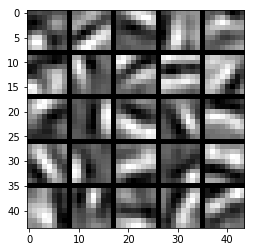

In [9]:
#Qn 3c
print('\nTraining neural network')
theta = initializeParameters(nH,nV)
opttheta,cost,messages = minimize(sparseAutoencoderCost,
theta,fprime=None,maxiter=400,args=(nV,nH,dW,sW,X))
W1,W2,b1,b2 = unravelParameters(opttheta,nH,nV)
plt.imshow(tile_raster_images(X=W1.T,
img_shape=(8,8),tile_shape=(5,5),
tile_spacing=(1,1)),cmap='gray')
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108208 entries, 0 to 108207
Data columns (total 4 columns):
date      108208 non-null object
userid    108208 non-null object
lat       108208 non-null float64
lon       108208 non-null float64
dtypes: float64(2), object(2)
memory usage: 3.3+ MB
None


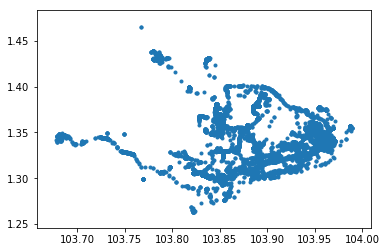

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18204 entries, 0 to 18203
Data columns (total 4 columns):
userid    18204 non-null object
date      18204 non-null datetime64[ns]
lat       18204 non-null float64
lon       18204 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 569.0+ KB
None


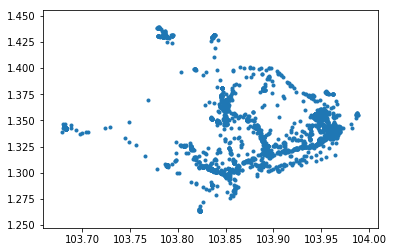

In [10]:
#Qn 4
import pandas as pd
from IPython.display import display
data = pd.read_csv('https://www.dropbox.com/s/8sat87lu7m5pksq/dataspark2.csv?dl=1')
data = data.drop(['seqid','index','acc','dir','spd'],axis=1)
print(data.info())
plt.scatter(data['lon'],data['lat'],marker='.')
plt.show()
#data = data.sample(frac=0.05,random_state=200)

data['date'] = pd.DatetimeIndex(data['date']).round('5min')
data = data.groupby(['userid','date']).mean().reset_index()
print(data.info())
plt.scatter(data['lon'],data['lat'],marker='.')
plt.show()

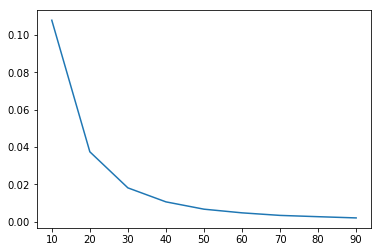

Optimal no of clusters is 20.


In [11]:
#Qn 4a
from sklearn.cluster import KMeans
smp = data[['lat','lon']].sample(n=3000,random_state=200)
score = []
cls_range = list(range(10,100,10))
for num_cls in cls_range:
    model = KMeans(n_clusters=num_cls).fit(smp)
    score.append(model.inertia_)
plt.plot(cls_range,score)
plt.show()
print ("Optimal no of clusters is 20.")

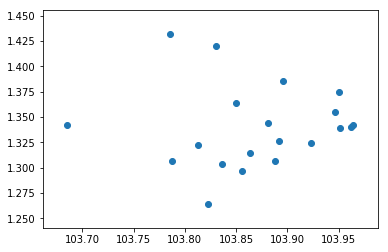

In [12]:
#Qn 4b
num_clusters = 20
smp = np.asarray(smp)
model = KMeans(n_clusters=num_clusters).fit(smp)
centroids = []
trg_label = model.predict(smp)
for i in range(num_clusters):
    sub_label = np.where(trg_label == i)
    centroids.append(np.mean(smp[sub_label],axis = 0))
centroids = np.asarray(centroids)
plt.scatter(centroids[:,1],centroids[:,0])
plt.show()

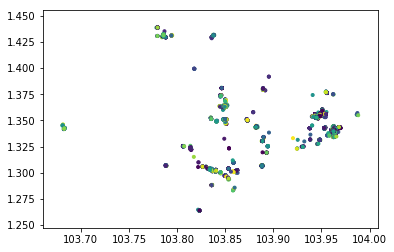

number of entries speed < 1 km/h = 14135


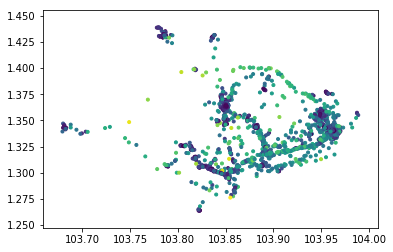

number of entries speed > 1 km/h = 4059


In [13]:
#Qn 4c
arr = []
for u in data['userid'].unique():
    user = data[data['userid']==u]
    date = pd.DatetimeIndex(user['date'])
    hour = (date-date[0])/np.timedelta64(1,'h')
    latlon = np.asarray(user[['lat','lon']])

    for i in range(len(latlon)):
        if (i == len(latlon) - 1):
            arr.append(np.NaN) #Last term set to nan, cannot compute speed.
            break
        speed = (((latlon[i+1,0] - latlon[i,0])**2 +\
                  (latlon[i+1,1] - latlon[i,1])**2)**0.5) /\
                (hour[i+1] - hour[i]) * 111
        arr.append(speed)        

data['speed'] = arr

stop = data[data['speed']<1]
plt.scatter(stop['lon'],stop['lat'],
c=np.log(stop['speed']+1),marker='.')
plt.show()
print('number of entries speed < 1 km/h =',stop.shape[0])
move = data[data['speed']>1]
plt.scatter(move['lon'],move['lat'],
c=np.log(move['speed']+1),marker='.')
plt.show()
print('number of entries speed > 1 km/h =',move.shape[0])

In [14]:
data = pd.read_csv('https://www.dropbox.com/s/8sat87lu7m5pksq/dataspark2.csv?dl=1')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108208 entries, 0 to 108207
Data columns (total 9 columns):
index     108208 non-null int64
date      108208 non-null object
seqid     108208 non-null int64
userid    108208 non-null object
acc       108208 non-null float64
dir       108208 non-null float64
lat       108208 non-null float64
lon       108208 non-null float64
spd       108208 non-null float64
dtypes: float64(5), int64(2), object(2)
memory usage: 7.4+ MB
None


In [15]:
display(data.head())

,index,date,seqid,userid,acc,dir,lat,lon,spd
0,4082,2017-10-14 11:57:18,106,Edsdw9bW18,22.057,-1.0,1.288156,103.835789,-1.0
1,4083,2017-10-14 11:57:25,106,Edsdw9bW18,23.287,-1.0,1.288137,103.835857,-1.0
2,4084,2017-10-14 11:57:34,106,Edsdw9bW18,23.101,-1.0,1.288083,103.835835,-1.0
3,4085,2017-10-14 11:57:40,106,Edsdw9bW18,22.015,-1.0,1.288101,103.835835,-1.0
4,4086,2017-10-14 11:57:48,106,Edsdw9bW18,20.400,-1.0,1.288227,103.835938,-1.0


In [16]:
import gmaps

ModuleNotFoundError: No module named 'gmaps'